<a href="https://colab.research.google.com/github/jpdeleon/chronos/blob/master/notebooks/examples-transit_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

if 'COLAB_GPU' in os.environ or 'google.colab' in str(get_ipython()):
    import sys
    if (sys.version_info.major, sys.version_info.minor)!=(3,6):
        #run prompt and select /usr/bin/python3.6
        !sudo update-alternatives --config python3
    !python3 -m pip install --user --upgrade pip
    !pip install git+https://github.com/jpdeleon/chronos.git@master

In [2]:
import chronos as cr

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## Initialize light curve

In [12]:
toiid = 1257
s=cr.ShortCadence(toiid=toiid)
s

Target: TOI 1257
Available sectors: [14]
Using sector=14.
Searching lightcurvefile for TIC 278348461 (sector 14).
Found 1 lightcurve(s).
Using TESS short cadence.



ShortCadence(mission=tess, toiid=1257, ticid=278348461, target_coord=(303.195,18.1048), all_sectors=[14], search_radius=3.0 arcsec, sap_mask=pipeline, quality_bitmask=default, calc_fpp=False)

In [13]:
#download PDCSAP lc
lc = s.get_lc(lctype='pdcsap')

Using period=5.4528 d, epoch=1686.83 BTJD, duration=3.53 hr.
Using biweight filter with window_length=0.44 day.


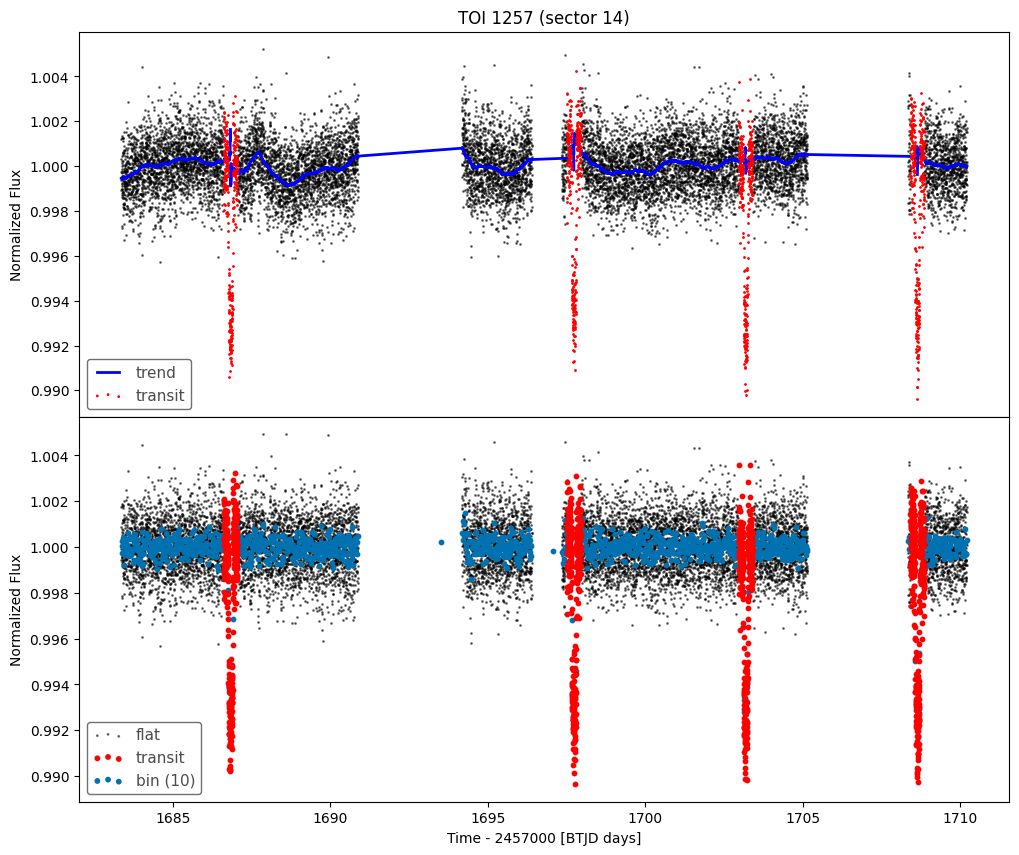

In [14]:
#plot raw, trend and flattened lc
#transits are automatically masked if TOI ephemeris is known
fig = s.plot_trend_flat_lcs(lc)

Using biweight filter with window_length=0.44 day.


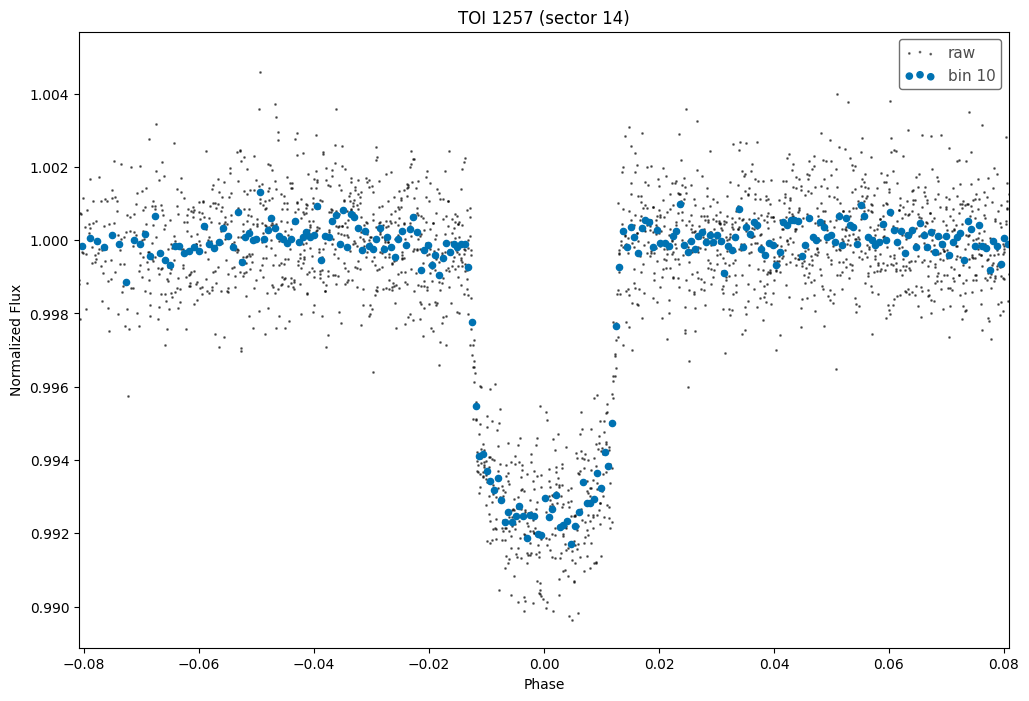

In [15]:
flat = s.get_flat_lc(lc)

#plot folded lc
ax = s.plot_fold_lc(flat)

## TLS periodogram

  0%|          | 0/2442 periods | 00:00<?

Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 28 durations
Searching 13806 data points, 2442 periods from 0.602 to 13.425 days
Using all 8 CPU threads


100%|██████████| 2442/2442 periods | 00:19<00:00


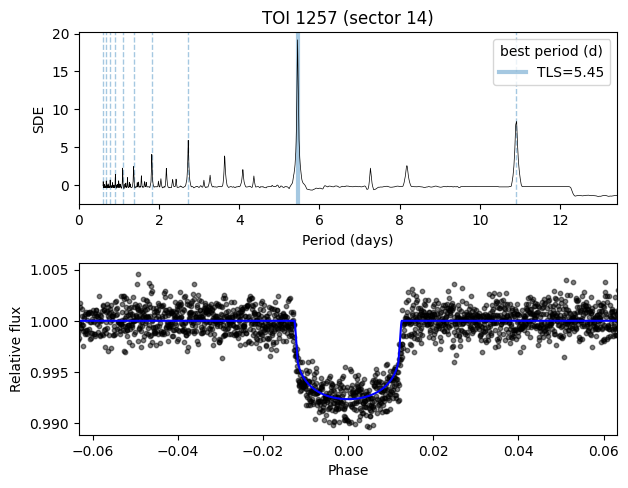

In [16]:
fig = s.run_tls(flat, plot=True)

In [17]:
s.tls_results

{'SDE': 19.165505295648902,
 'SDE_raw': 16.568378202724098,
 'chi2_min': 0.01806629238836594,
 'chi2red_min': 1.3089619177196016e-06,
 'period': 5.453094418168621,
 'period_uncertainty': 0.027030906274904787,
 'T0': 1686.8251393583032,
 'duration': 0.11490153066732961,
 'depth': 0.9923500243058343,
 'depth_mean': (0.9927041699583578, 7.11138654445419e-05),
 'depth_mean_even': (0.9927586881596981, 8.190595711173608e-05),
 'depth_mean_odd': (0.9925426345469797, 0.0001417634533969569),
 'transit_depths': array([0.99273819,        nan, 0.99284883, 0.99254263, 0.99269375]),
 'transit_depths_uncertainties': array([0.00013175,        nan, 0.00013722, 0.00014176, 0.00015472]),
 'rp_rs': 0.07865696309073031,
 'snr': 93.07437775239433,
 'snr_per_transit': array([46.82253668,  0.        , 44.68122712, 47.7893202 , 46.82093358]),
 'snr_pink_per_transit': array([49.27005048,  0.        , 48.5193221 , 50.59683349, 49.57155638]),
 'odd_even_mismatch': 0.9659506511288628,
 'transit_times': [1686.82513

## iterative masking and transit search

Using biweight filter with window_length=0.44 day.


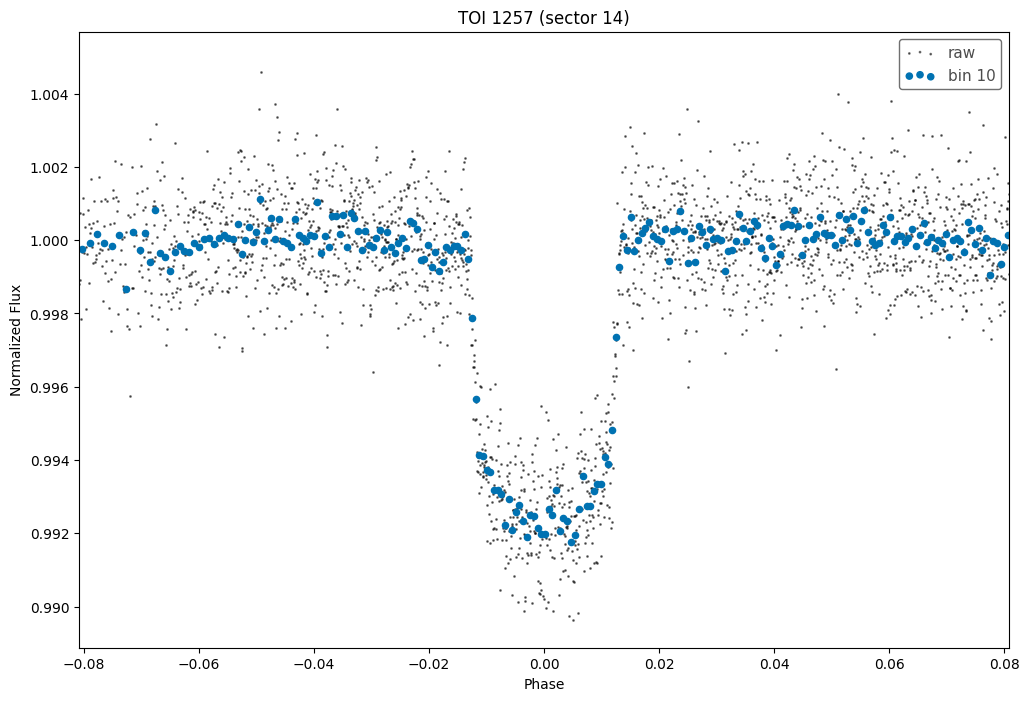

In [18]:
flat = s.get_flat_lc(lc)

#plot folded lc
ax = s.plot_fold_lc(flat,
                    period=s.tls_results['period'],
                    epoch=s.tls_results['T0']
                   )

## multi-sector

Target: TOI 2285
Available sectors: [16 17 24]
Using sector=16.
Searching lightcurvefile for TIC 329148988 (sector 16).
Found 1 lightcurve(s).
Using TESS short cadence.



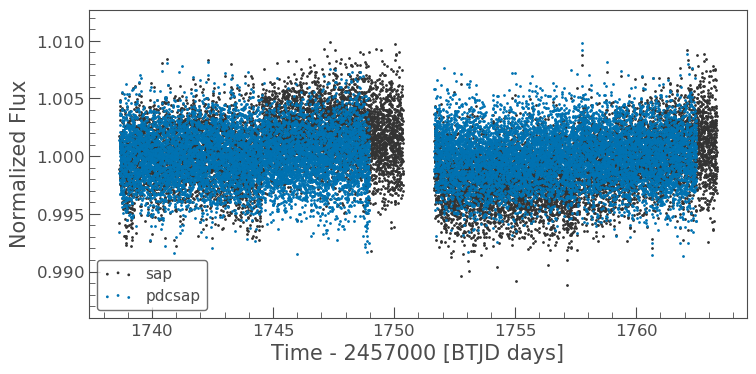

In [3]:
s = cr.ShortCadence(toiid=2285)

#get sap and pdcsap lcs of first available sector
sap = s.get_lc(lctype='sap')
pdcsap = s.get_lc(lctype='pdcsap')

ax = sap.scatter(label='sap')
pdcsap.scatter(label='pdcsap', ax=ax)

Searching lightcurvefile for TIC 329148988 (sector 17).
Found 1 lightcurve(s).


Text(0.5, 1.0, 'sectors [16 17 24]')

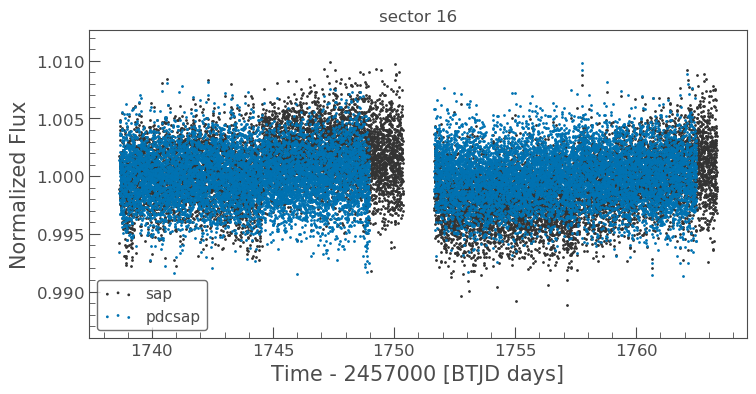

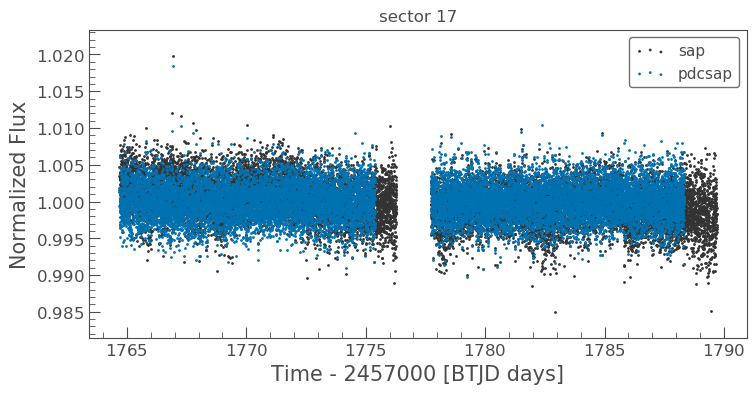

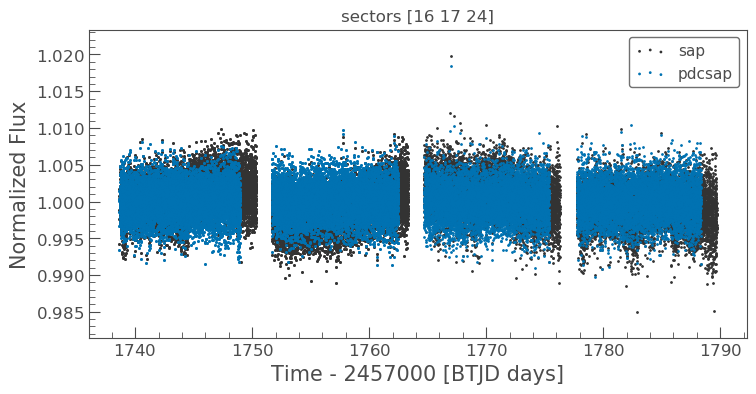

In [6]:
#append lcs in other sectors
for sector in [16,17]:
    lc1 = s.get_lc(lctype='sap', sector=sector)
    lc2 = s.get_lc(lctype='pdcsap', sector=sector)
    
    sap = sap.append(lc1)
    pdcsap = pdcsap.append(lc2)
    
    ax = lc1.scatter(label='sap')
    lc2.scatter(label='pdcsap', ax=ax)
    ax.set_title(f"sector {sector}")
    
#plot concatenated lcs
ax = sap.scatter(label='sap')
pdcsap.scatter(label='pdcsap', ax=ax)
ax.set_title(f"sectors {s.all_sectors}")

  0%|          | 0/5134 periods | 00:00<?

Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 33 durations
Searching 50101 data points, 5134 periods from 0.602 to 25.521 days
Using all 8 CPU threads


100%|██████████| 5134/5134 periods | 01:43<00:00


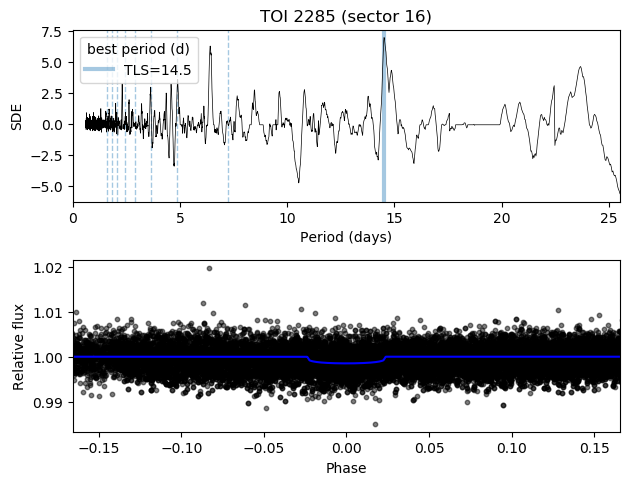

In [7]:
fig = s.run_tls(sap, plot=True)

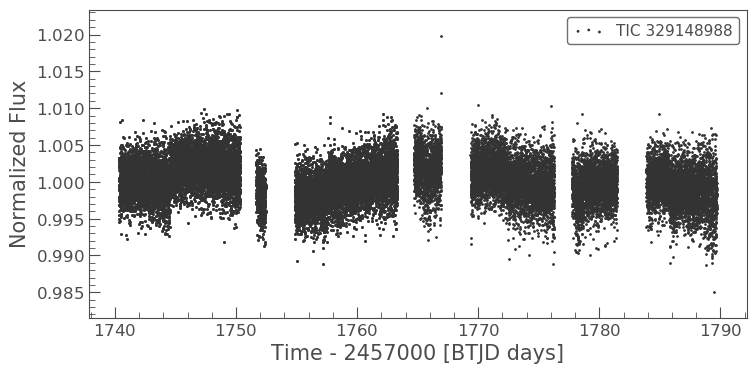

In [8]:
#get transit mask using TOI ephemeris
transit_mask = cr.get_transit_mask(sap,
                                   period=s.tls_results.period,
                                   epoch=s.tls_results.T0,
                                   duration_hours=s.tls_results.duration*24
                                  )
sap_masked = sap[~transit_mask]
sap_masked.scatter()

  0%|          | 0/4944 periods | 00:00<?

Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 32 durations
Searching 40872 data points, 4944 periods from 0.601 to 24.683 days
Using all 8 CPU threads


100%|██████████| 4944/4944 periods | 01:25<00:00


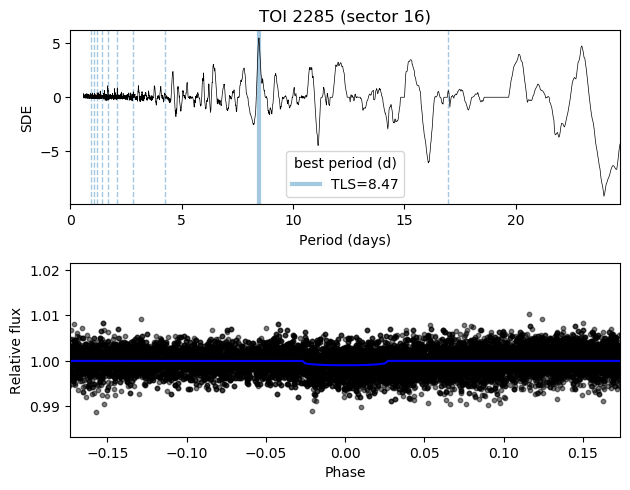

In [9]:
fig = s.run_tls(sap_masked, plot=True)